## File for filtering/noise characterization techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import warnings
import gc
warnings.filterwarnings("ignore")

In [2]:
working_path = r'C:\Users\willn2\BIOE 504 Anaconda Notebook'
dir_ephys_npy = os.path.join(working_path, 'data_1st_100_trials_vol_ephys.npy')
ephys = np.load(dir_ephys_npy)

### Plot one of the 100 trials 
- Display Signal
- Create time and frq domain arrays.
- Size is 1750076 elements long (sample rate = 1/25000)

Text(0.5, 1.0, 'Ephys test-one channel raw signal')

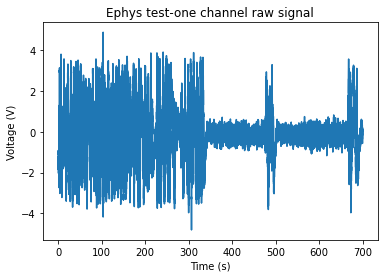

In [3]:
ephys_test1 = ephys[50,:]
#print(ephys_test1.size)

#Get total time duration for 100 trials: frq 25000 for all trials
samples = ephys_test1.size
frq = 1/25000
totaltime = samples*frq
#print(totaltime)

time = np.linspace(0,totaltime,samples)
#print(time.size,time[17500075])

plt.plot(time,ephys_test1)
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.title("Ephys test-one channel raw signal")

### Fourier Transform


In [7]:
from scipy.fft import fft, fftfreq, fftshift
freq = np.array(fftfreq(time.size, frq))
spect1 = np.array(fft(ephys_test1))

### Find the frequency spikes (where low and high frq components are). 

- very simple peak detect. Saves frq values (symmetric) over some user defined threshold

[ 1.49999349e-01  1.09373596e+04 -1.09373596e+04 -1.49999349e-01]


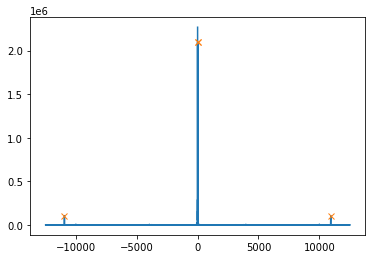

In [11]:
from scipy.signal import find_peaks
peaks1,_ = find_peaks(np.abs(spect1.real),distance = 100000,height = 20000)
LPF_freqidx1 = freq[peaks1]
LPF_power1 =(np.abs(spect1.real[peaks1]))
plt.plot(freq,np.abs(spect1.real))
print(LPF_freqidx1)
plt.plot(freq[peaks1],np.abs(spect1.real[peaks1]),"x")

## Zooming in on high frq (around 11 kHz)

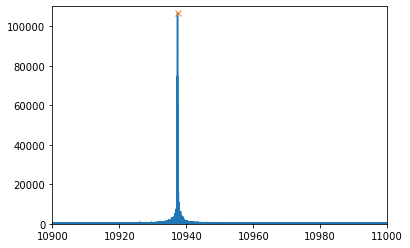

In [12]:

plt.plot(freq,np.abs(spect1.real))
plt.xlim([10900,11000])
plt.ylim([0,110000])
plt.plot(freq[peaks1],np.abs(spect1.real[peaks1]),"x")

## What happens when we remove the high frequency from the signal?
- I am first just using a noisy sin wave to test my filter design
- Low pass filter with cutoff 0.02 Hz...butter has relatively low cutoff slope so if you use butter you should start well before the frq you want to filter out
- Note for all filters the second input is cutoff frq (Hz) / (0.5*samplingfrq)

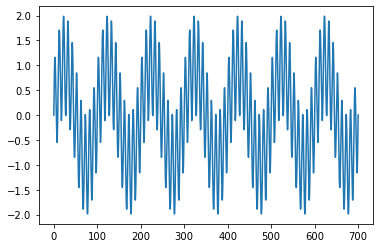

In [13]:
mysinwave = np.sin(time*2*0.010*np.pi)+np.sin(time*2*0.1*np.pi)
lowpass = scipy.signal.butter(2,0.02/12500,"low", output = 'sos')
plt.plot(time,mysinwave)

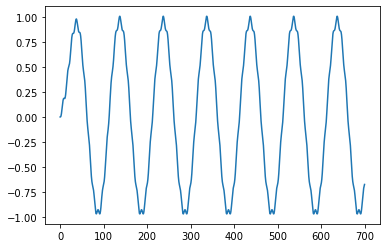

In [19]:
filtered = scipy.signal.sosfilt(lowpass,mysinwave)
plt.plot(time,filtered)

### Use Lp and Bp filters
- So I was originally going to show lowpass cutoff of 0.15 because thats where there was a maximum frq above...but I decided to try my best to get the filtered signal to "fit" to the trend of the noise and found 7 Hz works pretty well...You could use something like an envelope to smooth the peaks.

- the lower you make your cutoff frq the more the filtered signal will fit the LPF rather than the spiking. 

(0.0, 20.0)

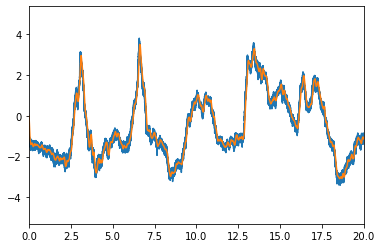

In [50]:
lowpass = scipy.signal.butter(2,7/12500,"low", output = 'sos')
plt.plot(time,ephys_test1)
filtered = scipy.signal.sosfilt(lowpass,ephys_test1)
plt.plot(time,filtered)
plt.xlim([0,20])

(0.0, 100.0)

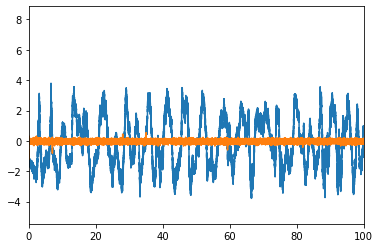

In [40]:
bandpass = scipy.signal.butter(2,[100/12500,9000/12500],"bandpass", output = 'sos')
plt.plot(time,ephys_test1)
filtered = scipy.signal.sosfilt(bandpass,ephys_test1)
plt.plot(time,filtered)
plt.xlim([0,100])

### Spectral analysis of the lowpass filtered signal. 
- printed values are peak frq values. Why is this useful? Good question. Not sure yet, but the techniques should be useful. Now we can filter out and characterize theoretically any frequency. 
- For LFP data, the frequency is going to be extremely low < 0.15 Hz which would be very hard to characterize...trail and error may be the best solution...
- I am also testing one one signal, may be better if I look at many.

[ 0.05714261 -0.05714261]


(-1.0, 1.0)

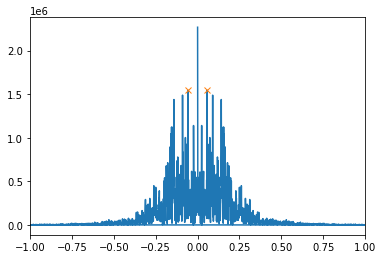

In [35]:
spect2 = np.array(fft(filtered))
plt.plot(freq,np.abs(np.real(spect2)))
peaks2,_ = find_peaks(np.abs(np.real(spect2)),distance = 500,height = 30000)
LPF_freqidx2 = freq[peaks2]
LPF_power2 =(np.abs(spect2.real[peaks2]))
print(LPF_freqidx2)
plt.plot(freq[peaks2],np.abs(spect2.real[peaks2]),"x")
plt.xlim([-1,1])

### High Pass 10 seconds
- can clearly see the filter takes out the low frq components (spikes) and just passes the high freq components (noise)
- really the same result as the bandpass, but keeps very high frqs

(0.0, 10.0)

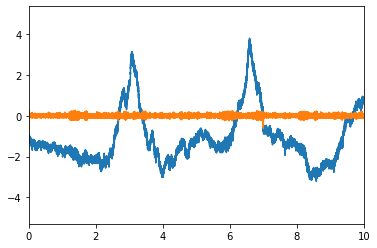

In [38]:
highpass = scipy.signal.butter(2,3000/25000,"highpass", output = 'sos')
plt.plot(time,ephys_test1)
filtered2 = scipy.signal.sosfilt(highpass,ephys_test1)
plt.plot(time,filtered2)
plt.xlim([0,10])

### Where to go from here:
- if we are trying to characterize spikes, try to use lowpass filtering to remove high frq components (or even just the spike finder tools because clearly the spikes are defined well in the raw signal data above...) and I think there is a way to do it using local maxima. 
- If we are trying to characterize noise what are we defining as our noise? 
- Convolutions
- Another thought is basis decomp...If we want to make a tool to use then we will need to decompose these signals because the memory to manipulate them is insanely large. 
